# Training Metrics Analysis
This notebook loads `runs/all_training_metrics.csv` (the master log you created while training) and plots trends for:
- reward
- total_loss
- policy_loss
- value_loss
- entropy

## How to use
1. Set `CSV_PATH` if your file lives elsewhere.
2. Run the **Setup** cell.
3. Use the helper functions to plot per-run/per-label curves.
4. Optionally set `rolling` window (e.g., 50) to smooth noisy curves.


In [25]:
# === Setup ===
stamp = "20250826_161717"
CSV_PATH = f"runs/all_training_metrics_{stamp}.csv"  # change this if needed

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from drl_framework import params

# Load
df = pd.read_csv(CSV_PATH)

# Basic sanity check / peek
print("Rows:", len(df))
print("Columns:", list(df.columns))
print("\nUnique run_id:", df['run_id'].nunique())
print("Unique labels:", sorted(df['label'].unique()))
print("\nSample rows:")
display(df.head())

# Sort for consistency
df = df.sort_values(['run_id','label','episode']).reset_index(drop=True)


Rows: 30000
Columns: ['run_id', 'label', 'episode', 'reward', 'policy_loss', 'value_loss', 'entropy', 'total_loss']

Unique run_id: 2
Unique labels: ['Global', 'Individual_0', 'Individual_1', 'Individual_2', 'Individual_3', 'Individual_4']

Sample rows:


,run_id,label,episode,reward,policy_loss,value_loss,entropy,total_loss
0,a3c_20250826_161717,Global,1,903.051224,-0.004606,22169.060352,1.097767,11084.524170
1,a3c_20250826_161717,Global,2,797.787800,-0.004517,9369.459180,1.097467,4684.724121
2,a3c_20250826_161717,Global,3,789.262145,0.007533,9733.013568,1.097636,4866.513214
3,a3c_20250826_161717,Global,4,875.004093,-0.003786,5260.588599,1.097535,2630.289496
4,a3c_20250826_161717,Global,5,859.354202,0.004874,15708.822559,1.098090,7854.414990


In [23]:
# === Helpers ===
def get_df(run_id=None, label=None):
    sub = df.copy()
    if run_id is not None:
        sub = sub[sub['run_id'] == run_id]
    if label is not None:
        sub = sub[sub['label'] == label]
    return sub.sort_values('episode')

def plot_metric(run_id=None, label=None, metric='reward', rolling=None, save=False, outdir='plots'):
    data = get_df(run_id, label)
    if data.empty:
        print("No data for the given filter.")
        return
    y = data[metric]
    if rolling is not None and rolling > 1:
        y = y.rolling(rolling, min_periods=1).mean()

    plt.figure()
    plt.plot(data['episode'], y)
    plt.xlabel('Episode')
    plt.ylabel(metric.replace('_',' ').title())
    title = f"{metric.replace('_',' ').title()} vs Episode"
    if label: title += f" - {label}"
    if run_id: title += f" - {run_id}"
    plt.title(title)
    plt.tight_layout()
    if save:
        Path(outdir).mkdir(parents=True, exist_ok=True)
        fname = f"{metric}_{(label or 'All')}_{(run_id or 'All')}.png".replace('/','-')
        plt.savefig(Path(outdir)/fname, dpi=180)
    plt.show()

def plot_compare_labels(run_id, metric='reward', rolling=None):
    data = df[df['run_id'] == run_id]
    if data.empty:
        print("No data for this run_id.")
        return
    labels = sorted(data['label'].unique())
    plt.figure()
    for lb in labels:
        sub = data[data['label'] == lb].sort_values('episode')
        series = sub[metric]
        if rolling is not None and rolling > 1:
            series = series.rolling(rolling, min_periods=1).mean()
        plt.plot(sub['episode'], series, label=lb)
    plt.xlabel('Episode')
    plt.ylabel(metric.replace('_',' ').title())
    plt.title(f"{metric.replace('_',' ').title()} vs Episode - {run_id}")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Quick start
- The next cell picks the most recent `run_id` by default and label `"Global"`.
- Adjust `RUN_ID` and `LABEL` as needed.


In [ ]:
# Pick defaults
# RUN_ID = df['run_id'].iloc[-1] if len(df) else None
RUN_ID = "individual_20250814_024420"
LABEL = "Global"  # or e.g., "Individual_0"

# Single-label plots (saved as PNG too)
plot_metric(RUN_ID, LABEL, 'reward', rolling=50, save=True)
plot_metric(RUN_ID, LABEL, 'total_loss', rolling=50, save=True)
plot_metric(RUN_ID, LABEL, 'policy_loss', rolling=50, save=True)
plot_metric(RUN_ID, LABEL, 'value_loss', rolling=50, save=True)
plot_metric(RUN_ID, LABEL, 'entropy', rolling=50, save=True)

# Compare all labels within a run (one chart per metric)
plot_compare_labels(RUN_ID, 'reward', rolling=50)
plot_compare_labels(RUN_ID, 'total_loss', rolling=50)
plot_compare_labels(RUN_ID, 'policy_loss', rolling=50)
plot_compare_labels(RUN_ID, 'value_loss', rolling=50)
plot_compare_labels(RUN_ID, 'entropy', rolling=50)


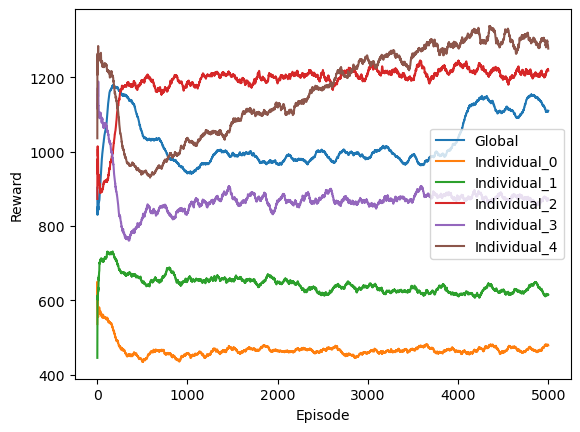

In [26]:
plt.figure()
rolling = 100

for label in sorted(df['label'].unique()):
    if label == 'Global':
        plt.plot(df[df['label']==label]['episode'], df[df['label']==label]['reward'].rolling(rolling, min_periods=1).mean(), label=label)
    else:
        plt.plot(df[df['label']==label]['episode'], df[df['label']==label]['reward'].rolling(rolling, min_periods=1).mean(), label=label)

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()

In [4]:
from drl_framework.networks import RecurrentActorCritic
from drl_framework.custom_env import make_env
from drl_framework.utils import flatten_dict_values
import drl_framework.params as params
import torch
import torch.nn.functional as F

device = params.device
ENV_PARAMS = params.ENV_PARAMS
REWARD_PARAMS = params.REWARD_PARAMS
hidden_dim = params.hidden_dim
n_workers = params.n_workers

# 임시 env로 상태/행동 차원 파악
temp_env_fn = make_env(**ENV_PARAMS)
temp_env = temp_env_fn()
sample_obs, _ = temp_env.reset()
state_dim = len(flatten_dict_values(sample_obs))
action_dim = temp_env.action_space.n
temp_env.close()

model_path = f"runs/a3c_{stamp}/models/global_final.pth"
model = RecurrentActorCritic(state_dim, action_dim, hidden_dim).to(device)
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [5]:
model.eval()
hx = model.init_hidden(batch_size=1, device=device)

with torch.no_grad():
    for i in range(10):  # 10번 반복 테스트
        # (1, 49) 크기의 랜덤 텐서 생성
        obs_tensor = torch.randn(1, 49, dtype=torch.float32, device=device)
        hx = model.init_hidden(batch_size=1, device=device) 

        logits, value, hx = model.step(obs_tensor, hx)
        print(f"\n=== Test {i+1} ===")
        print("Sample action logits:", logits.cpu().numpy())
        print("Prob distribution:", F.softmax(logits, dim=-1).cpu().numpy())


=== Test 1 ===
Sample action logits: [[ 1.5154613 -1.5669299 -1.2538335]]
Prob distribution: [[0.9020747  0.04135966 0.05656568]]

=== Test 2 ===
Sample action logits: [[-0.45662838 -4.8859606   1.7549114 ]]
Prob distribution: [[0.09860294 0.00117559 0.9002215 ]]

=== Test 3 ===
Sample action logits: [[ 1.8834412 -3.7209797 -0.2989024]]
Prob distribution: [[0.8956894  0.00329753 0.1010131 ]]

=== Test 4 ===
Sample action logits: [[-0.45836872 -4.96035     1.9562528 ]]
Prob distribution: [[8.198991e-02 9.090226e-04 9.171011e-01]]

=== Test 5 ===
Sample action logits: [[-0.04486919 -4.2846003   1.3958693 ]]
Prob distribution: [[0.19090436 0.00275121 0.80634445]]

=== Test 6 ===
Sample action logits: [[ 0.9902324  -3.2649152  -0.19518155]]
Prob distribution: [[0.75768447 0.0107523  0.23156324]]

=== Test 7 ===
Sample action logits: [[ 0.9612325 -4.568501   1.1256366]]
Prob distribution: [[0.45815706 0.00181753 0.5400254 ]]

=== Test 8 ===
Sample action logits: [[ 1.9503788  -0.45031732 -

In [6]:
def call_step_or_forward(model, obs, hx=None):
    """model.step이 있으면 (logits,value,hx)로 가정하고 호출,
       없으면 model(obs) 호출 (logits,value) 또는 logits 만 반환."""
    if hasattr(model, "step"):
        if hx is None and hasattr(model, "init_hidden"):
            hx = model.init_hidden(batch_size=obs.shape[0], device=obs.device)
        return model.step(obs, hx)
    else:
        out = model(obs)
        # 반환 형태 정리
        if isinstance(out, tuple):
            if len(out) == 3:   # (logits, value, hx)
                return out
            elif len(out) == 2: # (logits, value)
                logits, value = out
                return logits, value, None
        # logits만 있는 경우
        return out, None, None

In [7]:
def print_param_norms(model, topk=10):
    stats = []
    with torch.no_grad():
        for n, p in model.named_parameters():
            try:
                stats.append((n, p.norm().item(), p.abs().mean().item(), p.shape))
            except Exception:
                pass
    stats.sort(key=lambda x: x[1])  # norm 기준 오름차순
    print("\n[Param norms: smallest first]")
    for n, nrm, mean_abs, shape in stats[:topk]:
        print(f"{n:50s}  norm={nrm:.4e}  mean|p|={mean_abs:.4e}  shape={tuple(shape)}")
    print("\n[Param norms: largest first]")
    for n, nrm, mean_abs, shape in stats[-topk:][::-1]:
        print(f"{n:50s}  norm={nrm:.4e}  mean|p|={mean_abs:.4e}  shape={tuple(shape)}")

# 사용 예
model.eval()
print_param_norms(model)



[Param norms: smallest first]
policy.bias                                         norm=8.4864e-02  mean|p|=3.9268e-02  shape=(3,)
value.bias                                          norm=2.2639e-01  mean|p|=2.2639e-01  shape=(1,)
feature.0.bias                                      norm=4.6441e-01  mean|p|=3.7075e-02  shape=(128,)
policy.weight                                       norm=2.0207e+00  mean|p|=8.3301e-02  shape=(3, 128)
rnn.bias_hh_l0                                      norm=2.1597e+00  mean|p|=8.5255e-02  shape=(384,)
rnn.bias_ih_l0                                      norm=2.1828e+00  mean|p|=8.5330e-02  shape=(384,)
value.weight                                        norm=3.7587e+00  mean|p|=3.2552e-01  shape=(1, 128)
feature.0.weight                                    norm=8.0673e+00  mean|p|=7.8680e-02  shape=(128, 49)
rnn.weight_hh_l0                                    norm=1.6010e+01  mean|p|=5.8771e-02  shape=(384, 128)
rnn.weight_ih_l0                            

In [30]:
def scale_sensitivity_test(model, device, state_dim=49, trials=5, scales=(0.1, 1.0, 10.0)):
    model.eval()
    with torch.no_grad():
        for t in range(trials):
            base = torch.randn(1, state_dim, device=device)
            print(f"\n=== Trial {t+1}")
            for s in scales:
                obs = base * s
                # 매번 hidden 초기화(순환 상태 영향 제거)
                hx = model.init_hidden(1, device) if hasattr(model, "init_hidden") else None
                logits, value, _ = call_step_or_forward(model, obs, hx)
                probs = F.softmax(logits, dim=-1)
                print(f"scale={s:<4}: logits={logits.detach().cpu().numpy()}  probs={probs.detach().cpu().numpy()}")

# 사용 예
scale_sensitivity_test(model, device, state_dim=49)



=== Trial 1
scale=0.1 : logits=[[-0.47475374 -0.2897398 ]]  probs=[[0.45387802 0.546122  ]]
scale=1.0 : logits=[[-1.2214231  -0.00710053]]  probs=[[0.22893712 0.77106285]]
scale=10.0: logits=[[-1.7729201   0.76798356]]  probs=[[0.07303997 0.92696   ]]

=== Trial 2
scale=0.1 : logits=[[-0.7297659 -0.5716473]]  probs=[[0.46055248 0.5394475 ]]
scale=1.0 : logits=[[-0.85325205 -0.65654   ]]  probs=[[0.45097995 0.54902005]]
scale=10.0: logits=[[-0.85754687 -0.6570028 ]]  probs=[[0.45003137 0.54996866]]

=== Trial 3
scale=0.1 : logits=[[-0.6661822  -0.49808225]]  probs=[[0.4580737 0.5419263]]
scale=1.0 : logits=[[-0.82530844 -0.61775124]]  probs=[[0.4482962 0.5517038]]
scale=10.0: logits=[[-0.85754687 -0.6570028 ]]  probs=[[0.45003137 0.54996866]]

=== Trial 4
scale=0.1 : logits=[[-0.6506086 -0.5294117]]  probs=[[0.46973777 0.5302622 ]]
scale=1.0 : logits=[[-0.76812416 -0.627686  ]]  probs=[[0.46494806 0.53505194]]
scale=10.0: logits=[[-0.8575468 -0.6570028]]  probs=[[0.45003137 0.54996866]

In [21]:
df = pd.read_csv("a3c_global_env2_actions.csv")
print(f"Len df[df['action']==0]: {len(df[df['action']==0])}")
print(f"Len df[df['action']==1]: {len(df[df['action']==1])}")
print(f"Len df[df['action']==2]: {len(df[df['action']==2])}")


Len df[df['action']==0]: 594
Len df[df['action']==1]: 388
Len df[df['action']==2]: 18
